In [2]:
# Install dependencies
import sys
!{sys.executable} -m pip install pandas openpyxl scipy

Defaulting to user installation because normal site-packages is not writeable


In [3]:
# Read Excel file, organise data, then save as csv for faster loading next time
from os.path import exists
import pandas as pd
from math import floor

filestem = 'data/Compil_All'
fs = 100  # sampling rate

if exists(f"{filestem}.csv"):
    print("Loading CSV file...")
    df = pd.read_csv(f"{filestem}.csv")  # much much much quicker (once available)
    df = df.set_index('Time')
    no_participants = max(df['Subject'])
    print("Loaded.")
else:
    # Read Excel file (very slow as assumes rectangular data)
    print("Loading Excel file...")
    df = pd.read_excel(
        f"{filestem}.xlsx",
        header=1,  # Header row number
    )
    print("Loaded.")
    # Throw away blank columns
    df = df.drop(
        labels=(col for col in df.columns if 'Unnamed' in col),
        axis='columns',
    )
    # Give first participants' columns an id number (for consistency)
    cols = list(df.columns)
    metrics = cols[:6]
    cols[:6] = [f"{col}.0" for col in list(metrics)]
    df.columns = cols
    # Assign multi-column indexing to separate metrics from participant IDs
    no_participants = int(len(df.columns)/len(metrics))
    metrics_cols = no_participants * metrics
    participants_cols = [ floor((n+1)/len(metrics)) for n in range(no_participants*len(metrics)) ]
    multicol = [ metrics_cols, participants_cols ]
    df.columns = multicol
    # Make row index a time-series, given the sampling rate
    df = df.set_index(pd.Series(df.index)/fs)
    # Pivot table
    df = df.stack()
    # Remove blank rows
    df = df.dropna()
    # Convert indices to columns to preserve labels during CSV save/load
    df = df.reset_index()
    df.columns = ['Time', 'Subject', *metrics]
    # Save csv
    print("Saving CSV...")
    df.to_csv(f'{filestem}.csv', index=False)
    print("Done.")

# Preview dataframe (also let's us know its loaded)
print(df)

Loading CSV file...
Loaded.
        Subject   acc X   acc Y   acc Z     ang X    ang Y     ang Z
Time                                                                
0.00          1  0.8750  0.0537 -0.5269  175.7812 -59.2603  120.1080
0.00          2  1.1025  0.1973 -0.3481  141.5039 -72.8943  -27.4274
0.00          3  0.9282  0.1470 -0.4292  151.7157 -63.4845  -43.2312
0.00          4  0.9810  0.0610 -0.2710  164.4818 -74.3060  -46.6589
0.00          5  1.0078  0.1318 -0.1519  139.0100 -77.7448  -60.1007
...         ...     ...     ...     ...       ...      ...       ...
591.70        6  0.9639 -0.0952 -0.1182 -171.2604 -82.5293   27.1033
591.71        6  0.9639 -0.0952 -0.1182 -169.9750 -82.5238   28.2239
591.72        6  0.9199 -0.0938 -0.1240 -168.7994 -82.4854   29.4269
591.73        6  0.9199 -0.0938 -0.1240 -167.6349 -82.4469   30.6958
591.74        6  0.9111 -0.0933 -0.1299 -166.7505 -82.3535   32.0361

[528962 rows x 7 columns]


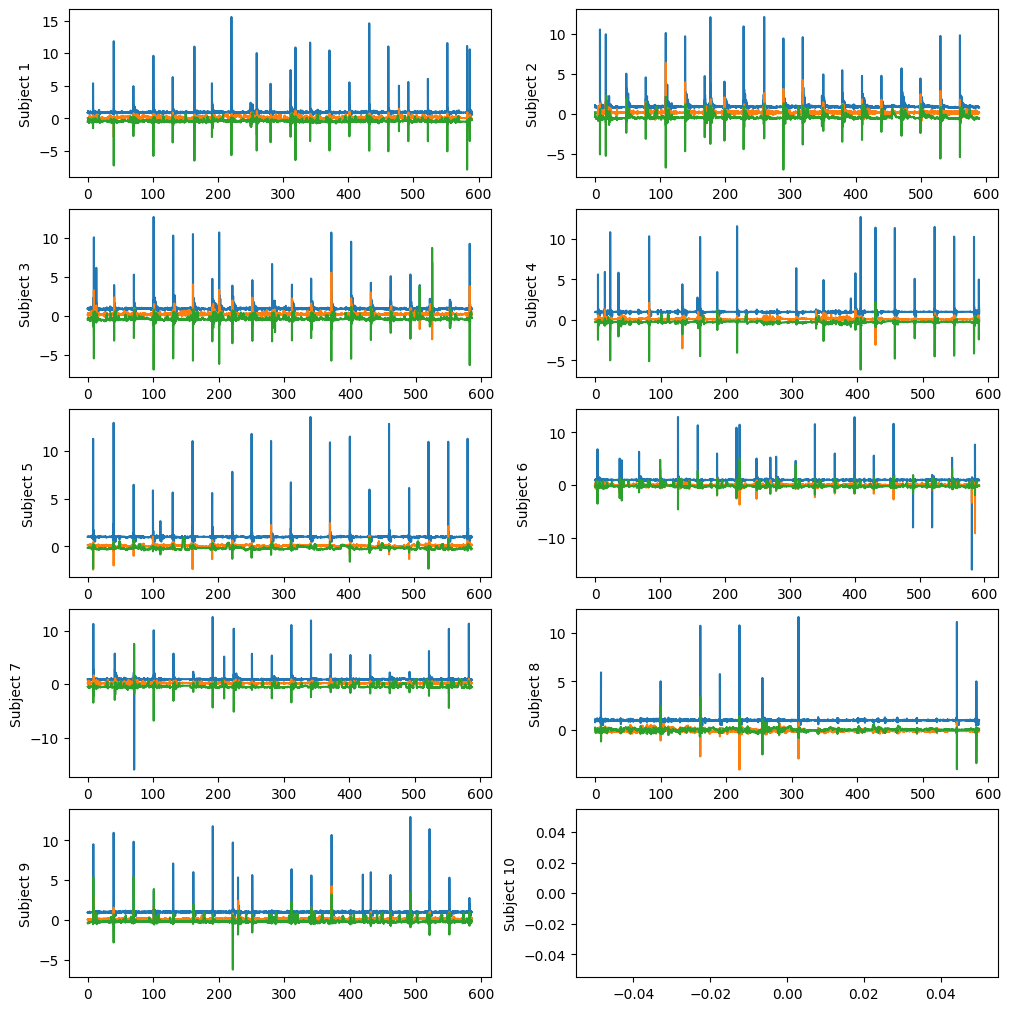

In [172]:
# Plot acceleration data (all subjects)
import matplotlib.pyplot as plt

fig, axs = plt.subplots(5, 2, figsize=(10,10), layout='constrained')
for subject, ax in enumerate(axs.flat):
    for metric in ['acc X', 'acc Y', 'acc Z']:
        y = df[metric][df['Subject']==subject+1]
        ax.plot(y)
        ax.set_ylabel(f'Subject {subject+1}')

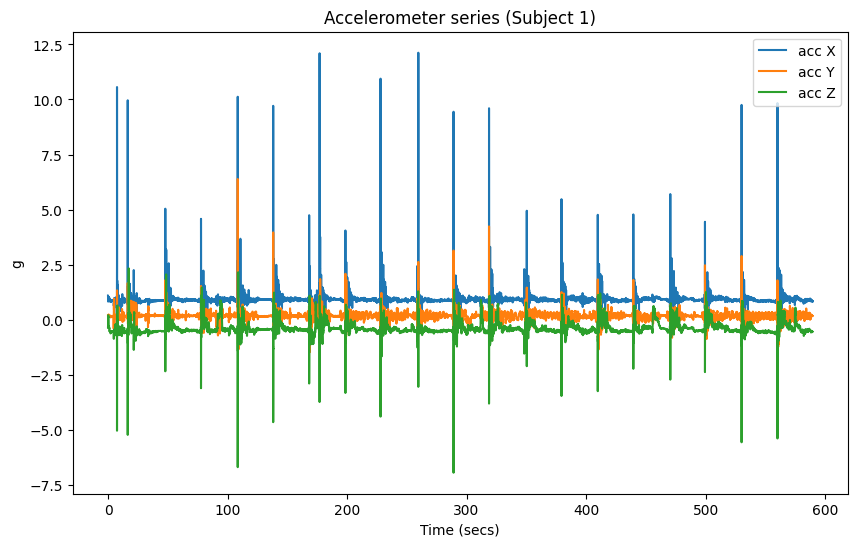

In [110]:
# Plot data (single subject)

subject = 1

plt.figure(figsize=(10,6))
plt.title(f'Accelerometer series (Subject {subject})')
plt.xlabel('Time (secs)')
plt.ylabel('g')
plot_metrics = ['acc X', 'acc Y', 'acc Z']
for metric in plot_metrics:
    y = df[metric][df['Subject']==subject+1]
    plt.plot(y)

plt.legend(plot_metrics)
plt.show()

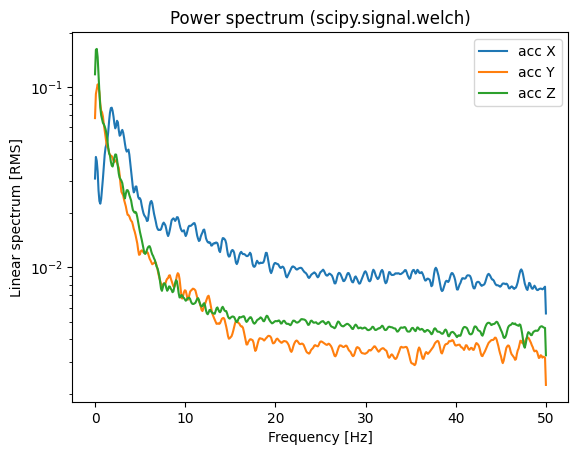

In [111]:
# Plot power spectrum of channels
import statistics
import numpy as np
from scipy import signal

subject = 1

plt.figure()
plt.title('Power spectrum (scipy.signal.welch)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [RMS]')
x = df.index[df['Subject']==subject+1]
plot_metrics = ['acc X', 'acc Y', 'acc Z']
for metric in plot_metrics:
    y = df[metric][df['Subject']==subject+1]
    y = y - statistics.mean(y)  # demean
    f, Pxx_spec = signal.welch(y, fs, 'flattop', 1024, scaling='spectrum')
    plt.semilogy(f, np.sqrt(Pxx_spec))

plt.legend(plot_metrics)
plt.show()

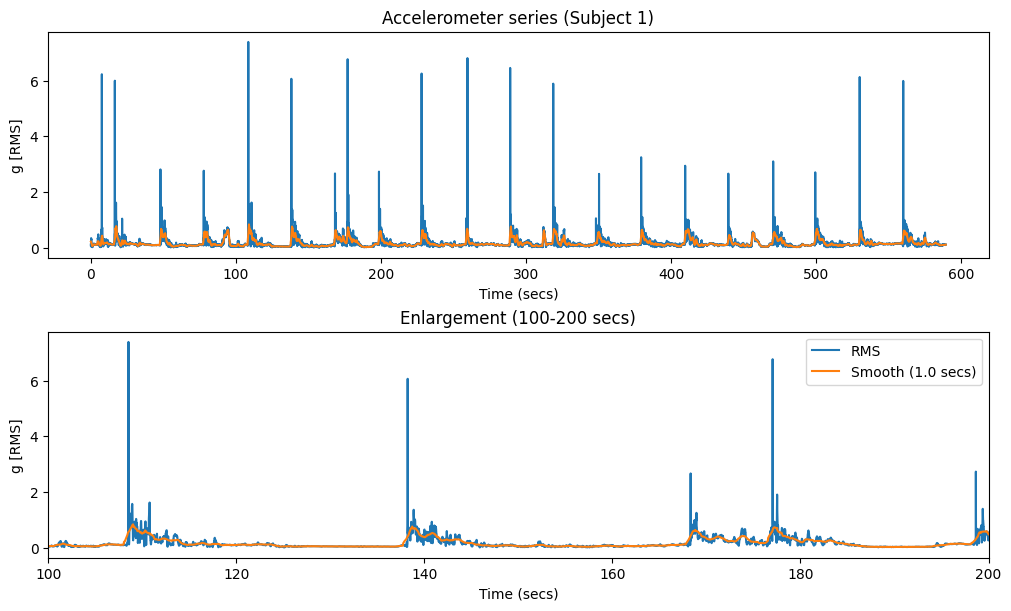

In [130]:
# Plot RMS (single subject)
from scipy.ndimage import uniform_filter1d

subject = 1

y1 = df['acc X'][df['Subject']==subject+1]
y1 -= statistics.mean(y1)
y2 = df['acc Y'][df['Subject']==subject+1]
y2 -= statistics.mean(y2)
y3 = df['acc Z'][df['Subject']==subject+1]
y3 -= statistics.mean(y3)

y_rms = pd.DataFrame(
    data={'rms': (( y1*y1 + y2*y2 + y3*y3 )/3 )**(1/2)},
)

# smoothed
smoothing_secs = 1.0  # smoothing length (secs)
ys = y_rms.copy()
ys['rms'] = uniform_filter1d(y_rms['rms'], size=int(smoothing_secs*fs))

# Draw two plots the same, then enlarge the second one for detail
fig, axs = plt.subplots(2, 1, figsize=(10,6), layout='constrained')
for subject, ax in enumerate(axs.flat):
    ax.set_xlabel('Time (secs)')
    ax.set_ylabel('g [RMS]')
    ax.plot(y_rms)
    ax.plot(ys)

axs[0].set_title(f'Accelerometer series (Subject {subject})')
axs[1].set_title('Enlargement (100-200 secs)')
axs[1].set_xlim(100, 200)
axs[1].legend(['RMS', f'Smooth ({smoothing_secs} secs)'])
plt.show()

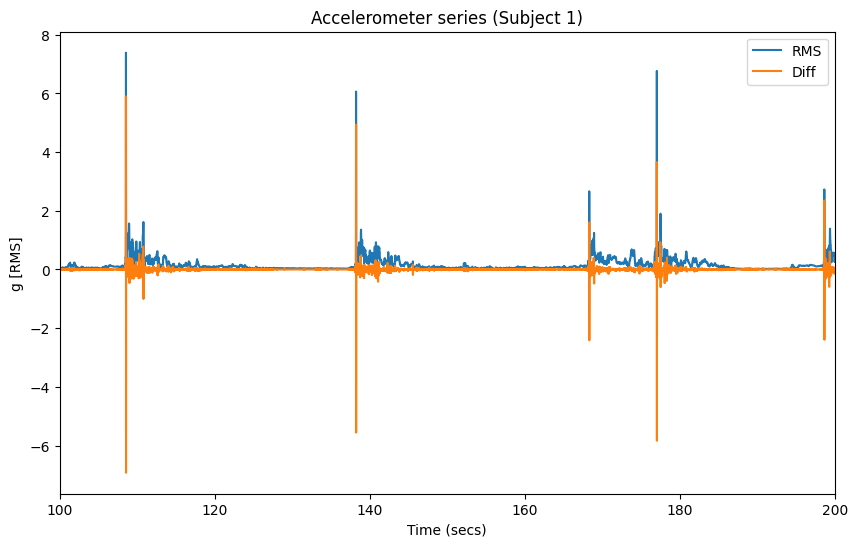

In [136]:
# Plot RMS and diff of RMS signal

plt.figure(figsize=(10, 6))
plt.title(f'Accelerometer series (Subject {subject})')
plt.xlabel('Time (secs)')
plt.ylabel('g [RMS]')
plt.plot(y_rms)
plt.plot(y_rms.diff())
plt.xlim(100, 200)
plt.legend(['RMS', 'Diff'])
plt.show()

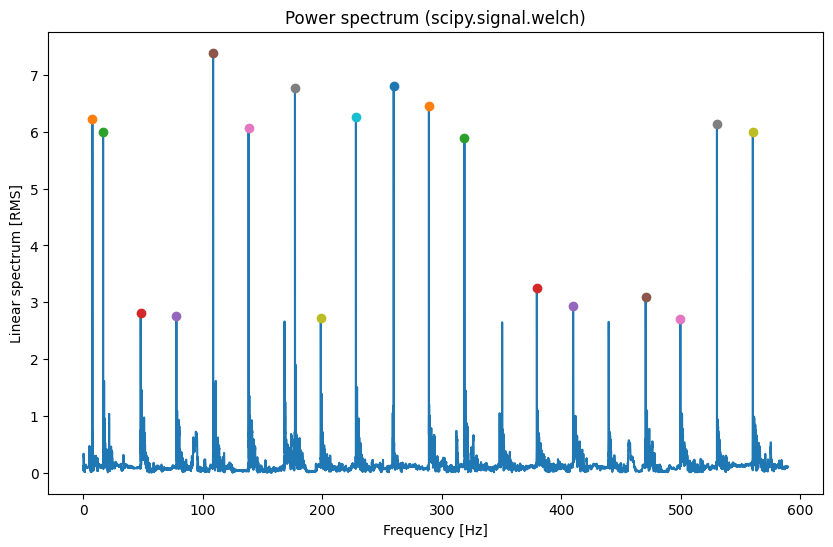

In [163]:
# Find and plot peaks
from scipy.signal import find_peaks

threshold = 2.0
min_separation_secs = 5.0  # minimum separation time (secs)

peaks = find_peaks(
    y_rms['rms'],
    threshold=threshold,
    distance=int(min_separation_secs*fs),
)

plt.figure(figsize=(10, 6))
plt.title('Power spectrum (scipy.signal.welch)')
plt.xlabel('Frequency [Hz]')
plt.ylabel('Linear spectrum [RMS]')
plt.plot(y_rms)
for peak_loc in peaks[0]:
    plt.plot(y_rms.index[peak_loc], y_rms.iloc[peak_loc], 'o')
plt.show()